In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('arxiv_papers.csv')
# Load the second CSV file
df2 = pd.read_csv('arxiv_papers2.csv')

# Combine the dataframes
df = pd.concat([df, df2], ignore_index=True)

In [2]:
# Display the first few rows of the DataFrame
df.head()

,title,abstract,category,published
0,Approximate inference of marginals using the I...,Exact inference of marginals in probabilistic ...,cs.AI,01-06-2023
1,Probabilistic Adaptation of Text-to-Video Models,Large text-to-video models trained on internet...,cs.AI,02-06-2023
2,PDT: Pretrained Dual Transformers for Time-awa...,Pre-training on large models is prevalent and ...,cs.AI,02-06-2023
3,Generative Adversarial Networks for Data Augme...,One way to expand the available dataset for tr...,cs.AI,03-06-2023
4,Painsight: An Extendable Opinion Mining Framew...,As the e-commerce market continues to expand a...,cs.AI,03-06-2023


In [3]:
# Summary statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,title,abstract,category,published
count,9593,9593,9593,9593
unique,9593,9593,4,985
top,Approximate inference of marginals using the I...,Exact inference of marginals in probabilistic ...,cs.CL,01-07-2024
freq,1,1,2400,97



Missing values:
title        0
abstract     0
category     0
published    0
dtype: int64


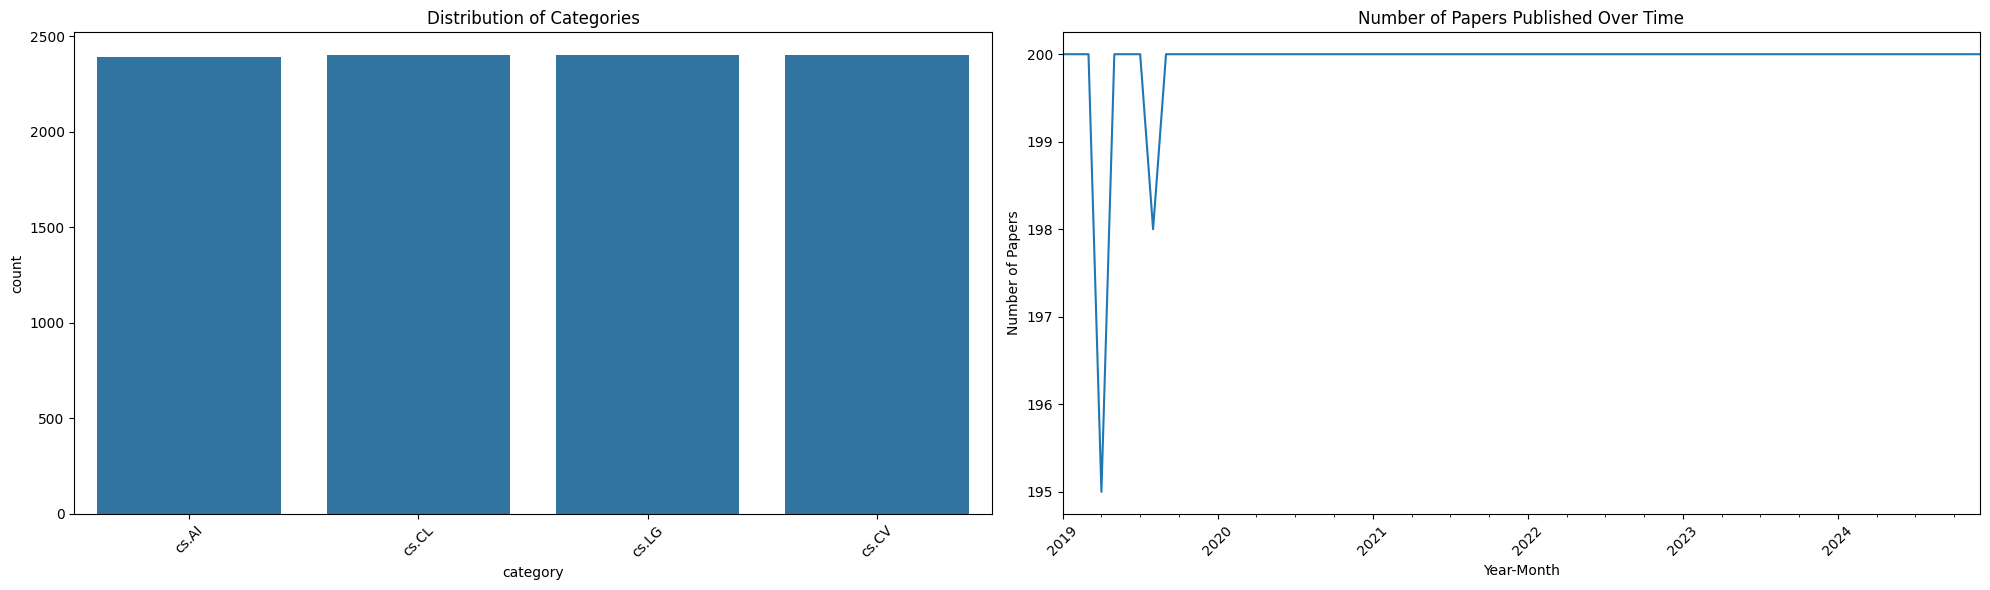

In [4]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Visualize the distribution of categories
sns.countplot(data=df, x='category', ax=axes[0])  # Plot on the first subplot
axes[0].set_title('Distribution of Categories')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Visualize time-based trends (assuming 'published' is in datetime format)
try:
    df['published'] = pd.to_datetime(df['published'], format='%d-%m-%Y')
    df['year_month'] = df['published'].dt.to_period('M')  # Extract year and month
    time_trend = df['year_month'].value_counts().sort_index()

    time_trend.plot(kind='line', ax=axes[1])  # Plot on the second subplot
    axes[1].set_title('Number of Papers Published Over Time')
    axes[1].set_xlabel('Year-Month')
    axes[1].set_ylabel('Number of Papers')
    axes[1].tick_params(axis='x', rotation=45)

except KeyError:
    print("\n'published' column not found. Skipping time-based trend analysis.")
except ValueError:
    print("\nCould not convert 'published' column to datetime.  Check the date format.")

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [5]:
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
from tqdm import tqdm

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to stem and lemmatize text
def stem_and_lemmatize(text):
    words = text.split()
    # stemmed = [stemmer.stem(word) for word in words]
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized)

# Show examples before and after stemming and lemmatizing
print("\nExamples Before and After Stemming and Lemmatizing:")
for i in range(min(7, len(df))):
    original = df['abstract'][i]
    cleaned = stem_and_lemmatize(original)
    print(f"Original Abstract {i+1}:\t{original}...")  # Show first 200 characters
    print(f"Cleaned Abstract {i+1}:\t{cleaned}...")  # Show first 200 characters

with tqdm_joblib(tqdm(desc="Stemming and Lemmatizing", total=len(df), leave=True, position=0)) as progress_bar:
    df['cleaned_abstract'] = Parallel(n_jobs=-1)(
        delayed(stem_and_lemmatize)(text) for text in df['abstract']
    )


c:\Users\arnav\anaconda3\envs\FAI_Project\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



Examples Before and After Stemming and Lemmatizing:
Original Abstract 1:	Exact inference of marginals in probabilistic graphical models (PGM) is known to be intractable, necessitating the use of approximate methods. Most of the existing variational techniques perform iterative message passing in loopy graphs which is slow to converge for many benchmarks. In this paper, we propose a new algorithm for marginal inference that is based on the incremental build-infer-approximate (IBIA) paradigm. Our algorithm converts the PGM into a sequence of linked clique tree forests (SLCTF) with bounded clique sizes, and then uses a heuristic belief update algorithm to infer the marginals. For the special case of Bayesian networks, we show that if the incremental build step in IBIA uses the topological order of variables then (a) the prior marginals are consistent in all CTFs in the SLCTF and (b) the posterior marginals are consistent once all evidence variables are added to the SLCTF. In our approach

Stemming and Lemmatizing:   0%|          | 0/9593 [00:00<?, ?it/s]

  0%|          | 0/9593 [00:00<?, ?it/s]

In [6]:
from gensim.models.phrases import Phrases, Phraser
import gensim.corpora as corpora

stop_words = stopwords.words('english')

custom_stop_words = ['this', 'our', 'propose', 'show', 'paper', 'study', 'new', 'method', 'also', 'use', 'based', 'result', 'data', 'using', 'approach', 'algorithm', 'algorithms', 'technique', 'techniques', 'system', 'systems', 'methodology', 'approach', 'methodologies', 'framework', 'frameworks', 'application', 'applications', 'analyze', 'demonstrate', 'evaluate', 'investigate', 'propose', 'develop', 'implement', 'design', 'assess', 'compare', 'examine', 'explore', 'identify', 'measure', 'model', 'optimize', 'simulate', 'validate']
stop_words.extend(custom_stop_words)
print("\nInitial Stop Words:", stop_words[:10], "...")  # Show first 10

# 3. Text Cleaning (with initial stop words)
def clean_text(text, stop_words):
    text = re.sub(r'[^\w\s]', '', str(text), re.UNICODE)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words and len(word) > 2])
    return text

print("\nExamples Before Initial Cleaning:")
for i in range(min(5, len(df))):
    print(f"Original Abstract {i+1}: {df['cleaned_abstract'][i]}")

with tqdm_joblib(tqdm(desc="Cleaning text", total=len(df), leave=True, position=0)) as progress_bar:
    df['cleaned_abstract'] = Parallel(n_jobs=-1)(
        delayed(clean_text)(text, stop_words) for text in df['cleaned_abstract']
    )

print("\nExamples After Initial Cleaning:")
print("\nExamples After Initial Cleaning:")
for i in range(min(5, len(df))):
    print(f"Cleaned Abstract {i+1}: {df['cleaned_abstract'][i]}")
    
# 4. Phrase Extraction using Gensim
sentences = [abstract.split() for abstract in df['cleaned_abstract']]  # Tokenize abstracts

# Create bigrams and trigrams
bigram = Phrases(sentences, min_count=5, threshold=100)
trigram = Phrases(bigram[sentences], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Force specific words to form bigrams/trigrams
forced_phrases = ['learning', 'model', 'models']
for phrase in forced_phrases:
    bigram.add_vocab([phrase.split()])
    trigram.add_vocab([phrase.split()])

# Form bigrams and trigrams
sentences = [bigram_mod[sentence] for sentence in sentences]
sentences = [trigram_mod[sentence] for sentence in sentences]

# Apply the Phraser model to your sentences
def apply_phraser(sentences, phraser):
    return phraser[sentences]

with tqdm_joblib(tqdm(desc="Applying Phraser", total=len(df), leave=True, position=0)) as progress_bar:
    df['phrase_abstract'] = Parallel(n_jobs=-1)(
        delayed(apply_phraser)(sentence, trigram_mod) for sentence in sentences
    )

# Show some before and after examples of phrases formed
print("\nExamples of Phrases Formed:")
for i in range(min(5, len(df))):
    print(f"Original Abstract {i+1}: {' '.join(sentences[i])}")
    print(f"Phrase Abstract {i+1}: {' '.join(df['phrase_abstract'][i])}\n")

# 5. Update Stopwords (remove unigrams if they form phrases)
all_phrases = []
for phrase_list in df['phrase_abstract']:
    all_phrases.extend(phrase_list)

phrase_words = [word for phrase in all_phrases for word in phrase.split('_')]

# Identify potential unigram stopwords
unigrams_to_remove = ['model', 'models', 'learning']
additional_stop_words = [word for word in unigrams_to_remove if word in phrase_words]

stop_words.extend(additional_stop_words)

# 6. TF-IDF and Low TF-IDF Removal (AFTER Phrase Detection)
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words.copy(), max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_abstract'])  # Use cleaned abstracts
terms = tfidf_vectorizer.get_feature_names_out()

# Calculate the sum of TF-IDF scores for each term
term_sums = tfidf_matrix.sum(axis=0).A1

# Identify low TF-IDF terms based on a threshold
tfidf_threshold = 20
low_tfidf_terms = [terms[i] for i in range(len(terms)) if term_sums[i] < tfidf_threshold]

stop_words.extend(low_tfidf_terms)

# 7. Final Text Cleaning - on the abstracts
print("\nExamples Before Final Cleaning:")
for i in range(min(5, len(df))):
    print(f"Cleaned Abstract {i+1}: {df['cleaned_abstract'][i]}")

def final_clean_text(text, stop_words):
    text = ' '.join([word for word in text.split() if word not in stop_words and len(word) > 2])
    return text

with tqdm_joblib(tqdm(desc="Cleaning text (final)", total=len(df), leave=True, position=0)) as progress_bar:
    df['cleaned_abstract'] = Parallel(n_jobs=-1)(
        delayed(final_clean_text)(text, stop_words) for text in df['cleaned_abstract']
    )

print("\nExamples After Final Cleaning:")
for i in range(min(5, len(df))):
    print(f"Cleaned Abstract {i+1}: {df['cleaned_abstract'][i]}")


Initial Stop Words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"] ...

Examples Before Initial Cleaning:
Original Abstract 1: Exact inference of marginals in probabilistic graphical model (PGM) is known to be intractable, necessitating the use of approximate methods. Most of the existing variational technique perform iterative message passing in loopy graph which is slow to converge for many benchmarks. In this paper, we propose a new algorithm for marginal inference that is based on the incremental build-infer-approximate (IBIA) paradigm. Our algorithm convert the PGM into a sequence of linked clique tree forest (SLCTF) with bounded clique sizes, and then us a heuristic belief update algorithm to infer the marginals. For the special case of Bayesian networks, we show that if the incremental build step in IBIA us the topological order of variable then (a) the prior marginals are consistent in all CTFs in the SLCTF and (b) the posterior marginals are co

Cleaning text:   0%|          | 0/9593 [00:00<?, ?it/s]

  0%|          | 0/9593 [00:00<?, ?it/s]


Examples After Initial Cleaning:

Examples After Initial Cleaning:
Cleaned Abstract 1: exact inference marginals probabilistic graphical pgm known intractable necessitating approximate methods existing variational perform iterative message passing loopy graph slow converge many benchmarks marginal inference incremental buildinferapproximate ibia paradigm convert pgm sequence linked clique tree forest slctf bounded clique sizes heuristic belief update infer marginals special case bayesian networks incremental build step ibia topological order variable prior marginals consistent ctfs slctf posterior marginals consistent evidence variable added slctf belief propagation step noniterative accuracycomplexity tradeoff controlled userdefined clique size bounds results several benchmark set recent uai competition give either better comparable accuracy existing variational sampling methods smaller runtimes
Cleaned Abstract 2: large texttovideo trained internetscale demonstrated exceptional capa

Applying Phraser:   0%|          | 0/9593 [00:00<?, ?it/s]

  0%|          | 0/9593 [00:00<?, ?it/s]


Examples of Phrases Formed:
Original Abstract 1: exact inference marginals probabilistic_graphical pgm known intractable necessitating approximate methods existing variational perform iterative message_passing loopy graph slow converge many benchmarks marginal inference incremental buildinferapproximate ibia paradigm convert pgm sequence linked clique tree forest slctf bounded clique sizes heuristic belief update infer marginals special_case bayesian networks incremental build step ibia topological order variable prior marginals consistent ctfs slctf posterior marginals consistent evidence variable added slctf belief_propagation step noniterative accuracycomplexity tradeoff controlled userdefined clique size bounds results several benchmark set recent uai competition give either better comparable accuracy existing variational sampling methods smaller runtimes
Phrase Abstract 1: exact inference marginals probabilistic_graphical pgm known intractable necessitating approximate methods ex

Cleaning text (final):   0%|          | 0/9593 [00:00<?, ?it/s]

  0%|          | 0/9593 [00:00<?, ?it/s]


Examples After Final Cleaning:
Cleaned Abstract 1: inference marginals probabilistic pgm known methods existing perform loopy graph many benchmarks inference buildinferapproximate ibia paradigm pgm sequence clique tree slctf clique heuristic marginals case bayesian networks build step ibia order variable prior marginals consistent ctfs slctf marginals consistent evidence variable slctf step noniterative accuracycomplexity userdefined clique size results several benchmark set recent uai give either better comparable accuracy existing sampling methods runtimes
Cleaned Abstract 2: large texttovideo trained internetscale demonstrated capability generating video textual however task limited pose significant computational challenge since finetuning pretrained large inspired small modifiable component prefixtuning adapt large language perform task without adapt large pretrained texttovideo variety downstream domain task without finetuning answering question video leverage score function larg

In [7]:
# Split the DataFrame into two based on the publication date
from sklearn.preprocessing import Normalizer

df_2020 = df[df['published'] < '2023-01-01']
df_2023 = df[df['published'] >= '2023-01-01']


In [8]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pandas as pd

# Function to perform clustering
def perform_clustering(df, stop_words, n_components=700):
    try:
        # Re-vectorize (with final stop words)
        vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=stop_words, max_features=2000)
        X = vectorizer.fit_transform(df['cleaned_abstract'])
        # Embedding (using Truncated SVD for dimensionality reduction)
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        svd_matrix = svd.fit_transform(X)
        svd_matrix = Normalizer().fit_transform(svd_matrix)
        print(f"Explained Variance Retained: {svd.explained_variance_ratio_.sum() * 100:.2f}%")
        return svd_matrix
    except Exception as e:
        print(f"Error during clustering: {e}")
        return None

# Function to perform clustering concurrently
def perform_clustering_concurrently(df_2020, df_2023, stop_words, n_components=700):
    with ThreadPoolExecutor() as executor:
        future_2020 = executor.submit(perform_clustering, df_2020, stop_words, n_components)
        future_2023 = executor.submit(perform_clustering, df_2023, stop_words, n_components)

        with tqdm(total=2, desc="Clustering", leave=True, position=0) as pbar:
            svd_matrix_2020 = future_2020.result()
            pbar.update(1)
            svd_matrix_2023 = future_2023.result()
            pbar.update(1)

    return svd_matrix_2020, svd_matrix_2023

# Example Usage (assuming df_2020, df_2023, stop_words are already defined)
svd_matrix_2020, svd_matrix_2023 = perform_clustering_concurrently(df_2020, df_2023, stop_words)

if svd_matrix_2020 is not None and svd_matrix_2023 is not None:
    print("Clustering completed successfully for both years.")
else:
    print("Clustering failed for at least one year.")


Clustering: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]

Explained Variance Retained: 92.49%
Explained Variance Retained: 92.40%
Clustering completed successfully for both years.


Calculating distortions: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


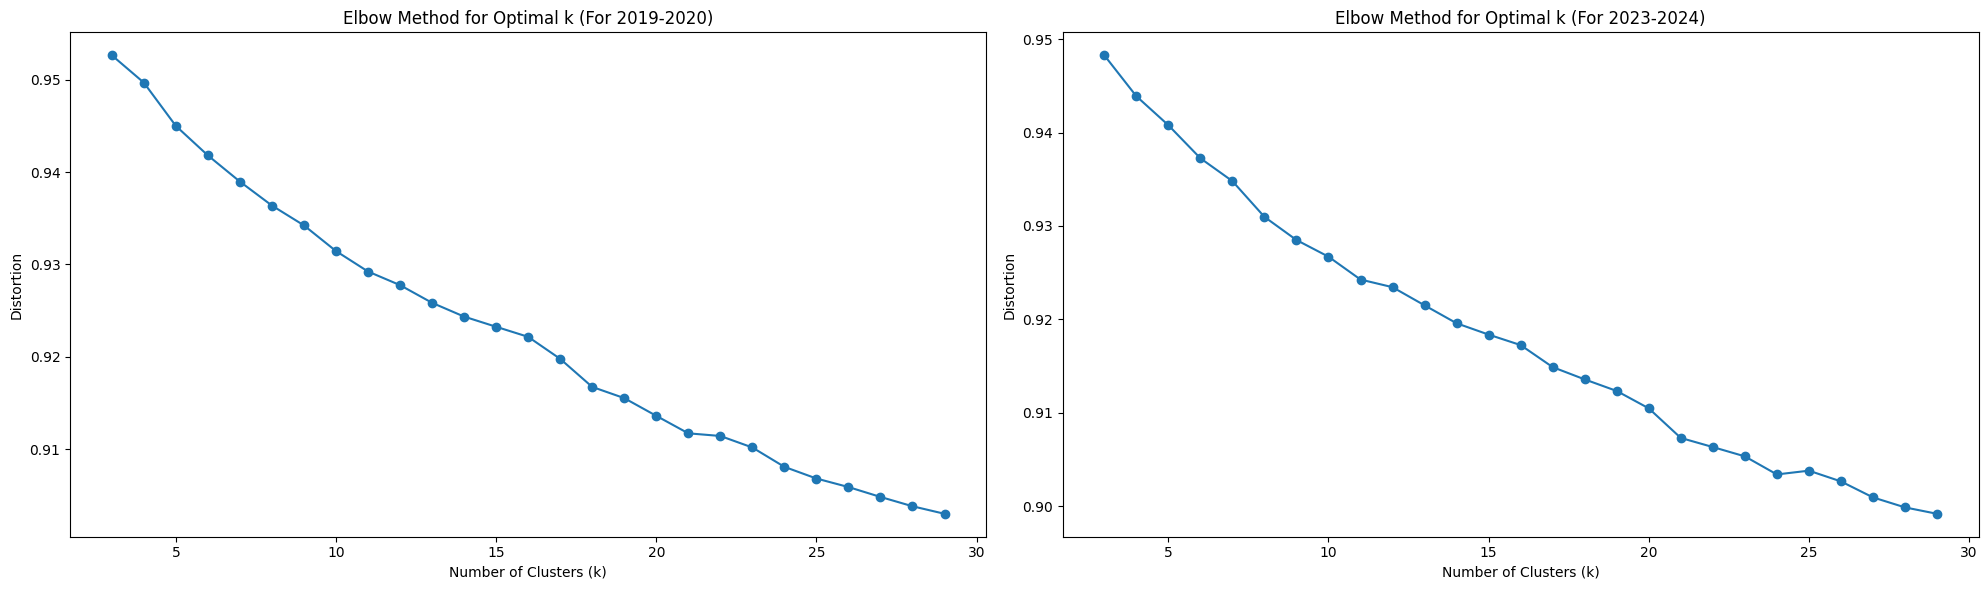

In [9]:
# Experiment with different values of k for KMeans clustering
import numpy as np
from scipy.spatial.distance import cdist

def calculate_distortion(svd_matrix, k_values):
    distortion = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(svd_matrix)
        distortion.append(sum(np.min(cdist(svd_matrix, kmeans.cluster_centers_, 'euclidean'), axis=1)) / svd_matrix.shape[0])
    return distortion

# Experiment with different values of k for KMeans clustering concurrently
k_values = range(3, 30)

with ThreadPoolExecutor() as executor:
    future_2020 = executor.submit(calculate_distortion, svd_matrix_2020, k_values)
    future_2023 = executor.submit(calculate_distortion, svd_matrix_2023, k_values)
    
    with tqdm(total=2, desc="Calculating distortions", leave=True, position=0) as pbar:
        distortion_2020 = future_2020.result()
        pbar.update(1)
        distortion_2023 = future_2023.result()
        pbar.update(1)

# Plot the distortion values to find the optimal k
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for svd_matrix_2020
axes[0].plot(k_values, distortion_2020, marker='o')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Distortion')
axes[0].set_title('Elbow Method for Optimal k (For 2019-2020)')

# Plot for svd_matrix_2023
axes[1].plot(k_values, distortion_2023, marker='o')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Distortion')
axes[1].set_title('Elbow Method for Optimal k (For 2023-2024)')

plt.tight_layout()
plt.show()


C:\Users\arnav\AppData\Local\Temp\ipykernel_77464\2872943957.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cluster'] = kmeans.fit_predict(svd_matrix)


Cluster 0: ['problem', 'proposed', 'performance', 'work', 'time', 'set', 'present', 'used', 'different', 'machine', 'agent', 'process', 'human', 'function', 'training', 'domain', 'decision', 'state', 'policy', 'game']
Cluster 1: ['task', 'knowledge', 'information', 'performance', 'dataset', 'text', 'datasets', 'training', 'representation', 'different', 'graph', 'semantic', 'proposed', 'sentence', 'evaluation', 'work', 'feature', 'stateoftheart', 'question', 'entity']
Cluster 2: ['language', 'word', 'translation', 'natural', 'task', 'text', 'performance', 'work', 'neural', 'machine', 'corpus', 'training', 'present', 'different', 'representation', 'languages', 'english', 'sentence', 'embeddings', 'tasks']
Cluster 3: ['network', 'neural', 'deep', 'training', 'performance', 'proposed', 'feature', 'accuracy', 'architecture', 'networks', 'convolutional', 'problem', 'work', 'graph', 'novel', 'datasets', 'input', 'task', 'classification', 'layer']
Cluster 4: ['image', 'object', 'feature', 'det

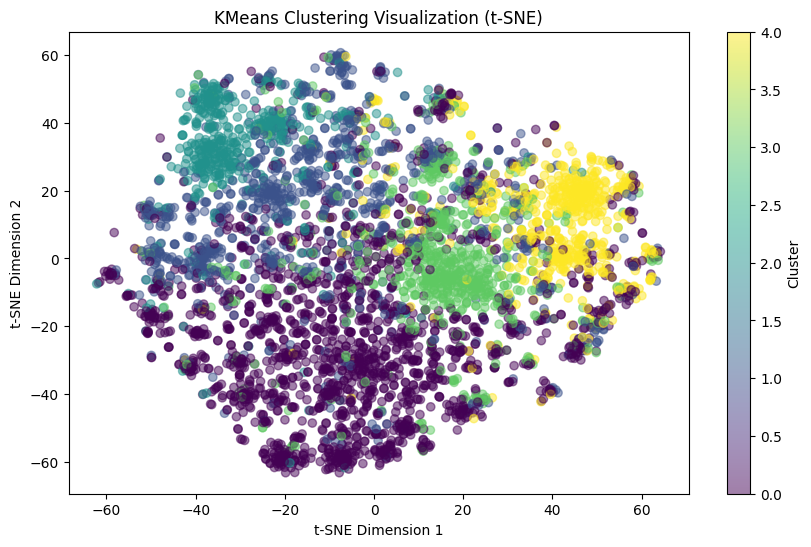

C:\Users\arnav\AppData\Local\Temp\ipykernel_77464\2872943957.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'cluster'] = kmeans.fit_predict(svd_matrix)


Cluster 0: ['network', 'graph', 'neural', 'training', 'performance', 'deep', 'representation', 'networks', 'problem', 'accuracy', 'proposed', 'task', 'prediction', 'work', 'novel', 'information', 'node', 'feature', 'datasets', 'existing']
Cluster 1: ['problem', 'work', 'research', 'human', 'present', 'task', 'analysis', 'different', 'knowledge', 'machine', 'used', 'performance', 'proposed', 'process', 'agent', 'information', 'evaluation', 'existing', 'text', 'policy']
Cluster 2: ['image', 'feature', 'information', 'diffusion', 'performance', 'images', 'proposed', 'training', 'segmentation', 'dataset', 'text', 'task', 'generation', 'datasets', 'network', 'visual', 'novel', 'different', 'object', 'semantic']
Cluster 3: ['llms', 'language', 'large', 'task', 'performance', 'llm', 'reasoning', 'knowledge', 'text', 'tasks', 'human', 'evaluation', 'natural', 'training', 'dataset', 'work', 'research', 'capability', 'datasets', 'benchmark']
Cluster 4: ['performance', 'training', 'feature', 'tas

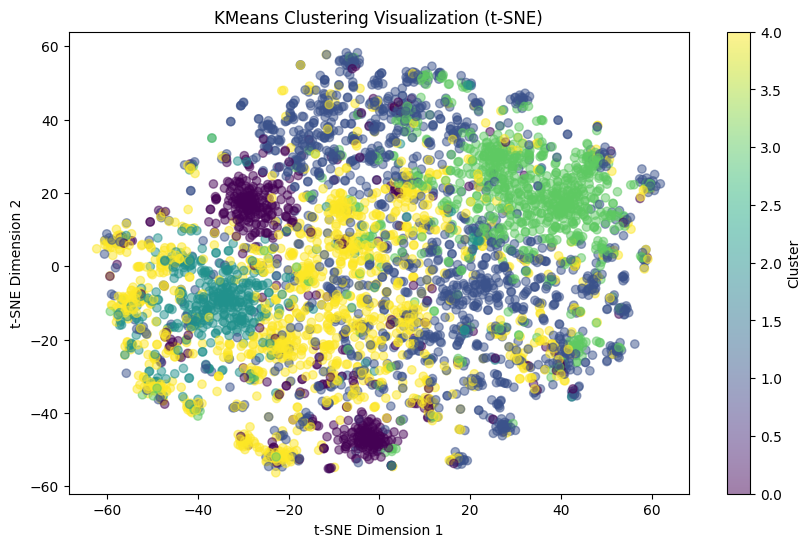

In [10]:
from sklearn.manifold import TSNE

def perform_clustering(df, svd_matrix, n_clusters=5):
    """
    Perform KMeans clustering on the given DataFrame and SVD matrix.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        svd_matrix (np.ndarray): SVD matrix for the data.
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        pd.DataFrame: DataFrame with an additional 'cluster' column.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    df.loc[:, 'cluster'] = kmeans.fit_predict(svd_matrix)

    # Print top terms per cluster
    for cluster_id in range(n_clusters):
        cluster_text = df[df['cluster'] == cluster_id]['cleaned_abstract']
        if cluster_text.empty:
            print(f"Cluster {cluster_id}: [No documents]")
            continue
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
        tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_text)
        try:
            top_words_idx = tfidf_matrix.sum(axis=0).argsort()[0, ::-1].tolist()[0]
            top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        except IndexError:
            top_words = ["No significant terms"]
        print(f"Cluster {cluster_id}: {top_words}")
    
    # Reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_matrix = tsne.fit_transform(svd_matrix)

    # Visualize the t-SNE clustering
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_matrix[:, 0], tsne_matrix[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('KMeans Clustering Visualization (t-SNE)')
    plt.show()

    return df

# Perform clustering for both time periods
df_2020 = perform_clustering(df_2020, svd_matrix_2020, n_clusters=5)
df_2023 = perform_clustering(df_2023, svd_matrix_2023, n_clusters=5)

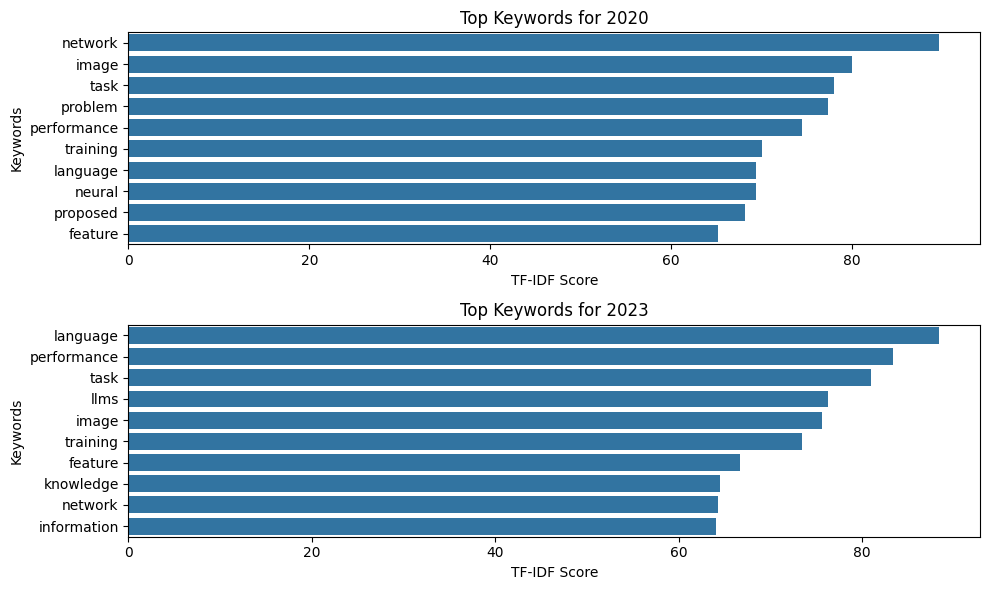

In [11]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_keywords_for_df(df, n_terms=10):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95,ngram_range=(1,3), min_df=2, stop_words=stop_words)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_abstract'])
    sum_tfidf = tfidf_matrix.sum(axis=0)
    words_freq = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return sorted_words[:n_terms]

def plot_top_keywords(df_2020, df_2023):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))

    # Plot for 2020
    top_words_2020 = get_top_keywords_for_df(df_2020)
    words_2020, freqs_2020 = zip(*top_words_2020)
    sns.barplot(x=freqs_2020, y=words_2020, ax=axes[0])
    axes[0].set_title('Top Keywords for 2020')
    axes[0].set_xlabel('TF-IDF Score')
    axes[0].set_ylabel('Keywords')

    # Plot for 2023
    top_words_2023 = get_top_keywords_for_df(df_2023)
    words_2023, freqs_2023 = zip(*top_words_2023)
    sns.barplot(x=freqs_2023, y=words_2023, ax=axes[1])
    axes[1].set_title('Top Keywords for 2023')
    axes[1].set_xlabel('TF-IDF Score')
    axes[1].set_ylabel('Keywords')

    plt.tight_layout()
    plt.show()

# Plot top keywords for each time period
plot_top_keywords(df_2020, df_2023)


In [12]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from concurrent.futures import ThreadPoolExecutor

def perform_lda_for_time_period(df, period_name, num_topics=10):
    """
    Performs LDA topic modeling for a given time period.

    Args:
        df (pd.DataFrame): DataFrame containing the data for the time period.
        period_name (str): Name of the time period.
        num_topics (int): Number of topics to extract.

    Returns:
        tuple: (LdaModel, gensim.corpora.Dictionary, list) if successful, otherwise (None, None, None).
    """
    try:
        # Prepare data for LDA
        documents = [text.split() for text in df['cleaned_abstract']]

        # Create bigrams and trigrams
        bigram = Phrases(documents, min_count=5, threshold=200)
        trigram = Phrases(bigram[documents], threshold=200)
        bigram_mod = Phraser(bigram)
        trigram_mod = Phraser(trigram)

        # Form bigrams and trigrams
        documents = [bigram_mod[doc] for doc in documents]
        documents = [trigram_mod[bigram_mod[doc]] for doc in documents]
        documents = [[word for word in doc if word not in stop_words] for doc in documents]

        # Create dictionary and corpus
        dictionary = corpora.Dictionary(documents)
        corpus = [dictionary.doc2bow(doc) for doc in documents]

        # Show some examples of the documents
        print(f"Example documents for {period_name}:")
        for i, doc in enumerate(documents[:20]):
            print(f"Document {i + 1}: {' '.join(doc)}")
        
        # Train LDA model
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)

        # Print topics
        print(f"\nTopics for {period_name}:")
        for topic_id, topic in lda_model.print_topics(num_words=10):
            print(f"Topic {topic_id + 1}: {topic}")

        # Evaluate model using coherence score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print(f'Coherence Score for {period_name}: {coherence_lda}')
        
        return lda_model, dictionary, corpus

    except Exception as e:
        print(f"Error performing LDA for {period_name}: {e}")
        return None, None, None

def analyze_year(df, year, num_topics=10):
    """
    Analyzes the given DataFrame by performing LDA topic modeling for the entire year.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        year (int): Year for the analysis.
        num_topics (int): Number of topics to extract.

    Returns:
        dict: Dictionary containing LDA models, dictionaries, and corpora for the year.
    """
    period_df = df[df['published'].dt.year == year]
    period_name = str(year)

    print(f"\nAnalyzing year: {period_name}")

    if len(period_df) > 0:
        lda_model, dictionary, corpus = perform_lda_for_time_period(period_df, period_name, num_topics)
        if lda_model:
            return {'model': lda_model, 'dictionary': dictionary, 'corpus': corpus}
    else:
        print("No data for this year.")
        return None

def compare_topics(topics, period1, period2):
    """
    Compares topics between two time periods based on word overlap.

    Args:
        topics (dict): Dictionary of topics for all time periods.
        period1 (str): Name of the first time period.
        period2 (str): Name of the second time period.
    """
    print(f"\nComparing topics between {period1} and {period2}:")
    
    if period1 not in topics or period2 not in topics:
        print("One or both periods not found.")
        return
    
    lda_model1 = topics[period1]['model']
    lda_model2 = topics[period2]['model']
    
    for topic_id1 in range(lda_model1.num_topics):
        topic1_words = [word for word, prob in lda_model1.show_topic(topic_id1, topn=10)]
        print(f"\nTopic {topic_id1 + 1} in {period1}: {topic1_words}")
        
        for topic_id2 in range(lda_model2.num_topics):
            topic2_words = [word for word, prob in lda_model2.show_topic(topic_id2, topn=10)]
            
            common_words = set(topic1_words) & set(topic2_words)
            print(f"  Compared to Topic {topic_id2 + 1} in {period2}: {topic2_words}")
            print(f"    Common words: {common_words}")

# Function to analyze a single year
def analyze_single_year(year):
    return analyze_year(df, year, num_topics=10)

# Analyze years 2020 and 2023 in parallel
with ThreadPoolExecutor() as executor:
    future_2020 = executor.submit(analyze_single_year, 2020)
    future_2023 = executor.submit(analyze_single_year, 2023)
    topics_2020 = future_2020.result()
    topics_2023 = future_2023.result()

# Example usage of compare_topics (compare topics of 2020 and 2023)
if topics_2020 and topics_2023:
    compare_topics({'2020': topics_2020, '2023': topics_2023}, '2020', '2023')



Analyzing year: 2020

Analyzing year: 2023
Example documents for 2020:
Document 1: referential game offer environment neural agent account fact language functionally used however take account second constraint considered fundamental shape human language must language cogswell introduced within referential game agent language however resulting language agents underlying work introduce language agents core contribution empirically optimal take account bias language thus language agent coevolve agent achieve across improvement considered metric gain made importance underlying agent architecture way coevolution language agent language
Document 2: transformer applied many natural language processing tasks however textual sequence matching simple matching representation pair sequence noise sequence pair matching transformer headwise matching representation multiple experiments proposed achieve stateoftheart performance multiple task rely precomputed sequencevectorrepresentation snli mnlimat

Applying Phraser:   0%|          | 0/9593 [01:52<?, ?it/s]


Coherence Score for 2020: 0.3062475538276327
Coherence Score for 2023: 0.31977894791594264

Comparing topics between 2020 and 2023:

Topic 1 in 2020: ['network', 'task', 'graph', 'prediction', 'knowledge', 'performance', 'image', 'feature', 'problem', 'deep']
  Compared to Topic 1 in 2023: ['task', 'information', 'performance', 'proposed', 'detection', 'language', 'feature', 'dataset', 'text', 'novel']
    Common words: {'task', 'performance', 'feature'}
  Compared to Topic 2 in 2023: ['language', 'llms', 'text', 'training', 'attention', 'large', 'feedback', 'performance', 'natural', 'task']
    Common words: {'task', 'performance'}
  Compared to Topic 3 in 2023: ['llms', 'generation', 'image', 'language', 'task', 'object', 'performance', 'text', 'scene', 'prompt']
    Common words: {'task', 'performance', 'image'}
  Compared to Topic 4 in 2023: ['training', 'datasets', 'performance', 'action', 'problem', 'however', 'loss', 'work', 'domain', 'task']
    Common words: {'problem', 'perfo

In [13]:
# Visualize topics using pyLDAvis (optional - requires installation)
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Prepare the visualization for 2020
lda_display_2020 = gensimvis.prepare(topics_2020['model'], topics_2020['corpus'], topics_2020['dictionary'], sort_topics=False)
print("LDA Visualization for 2020:")
pyLDAvis.display(lda_display_2020)

LDA Visualization for 2020:


In [14]:
# Prepare the visualization for 2023
lda_display_2023 = gensimvis.prepare(topics_2023['model'], topics_2023['corpus'], topics_2023['dictionary'], sort_topics=False)
print("LDA Visualization for 2023:")
pyLDAvis.display(lda_display_2023)

LDA Visualization for 2023:
